# Simulación y diseño de respuestas acústicas

Transformación de impulsos en patrones sonoros usando convolución y simulación de RIR.

Este cuaderno permite: (1) Cargar o sintetizar un impulso (por ejemplo, un aplauso). (2) Generar respuestas al impulso (RIR) mediante dos enfoques: una sala tipo shoebox con Pyroomacoustics, y un modelo simplificado de estructura escalonada. (3) Aplicar convolución para escuchar y analizar el resultado (ondas y espectrograma).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import ipywidgets as widgets
import pyroomacoustics as pra

plt.rcParams['figure.figsize'] = (10, 4)

print('Entorno listo.')

Entorno listo.


In [2]:
# Utilidades de audio y visualización
def normalize_audio(x, peak=0.98):
    x = np.asarray(x, dtype=float)
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * peak

def load_audio(path, target_sr=None, mono=True):
    x, sr = sf.read(path, always_2d=False)
    if x.ndim > 1 and mono:
        x = x.mean(axis=1)
    if target_sr is not None and sr != target_sr:
        # Re-muestreo con scipy
        g = np.gcd(sr, target_sr)
        up = target_sr // g
        down = sr // g
        x = signal.resample_poly(x, up, down)
        sr = target_sr
    return x.astype(float), sr

def save_audio(path, x, sr):
    sf.write(path, x, sr)

def plot_waveform(x, sr, title='Senal'):
    t = np.arange(len(x)) / sr
    plt.figure()
    plt.plot(t, x)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(x, sr, title='Espectrograma'):
    f, t, Sxx = signal.spectrogram(x, fs=sr, nperseg=1024, noverlap=512, scaling='spectrum')
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    plt.figure()
    plt.pcolormesh(t, f, Sxx_db, shading='auto', cmap='magma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.ylim(0, sr/2)
    plt.title(title)
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

def play(x, sr):
    display(Audio(x, rate=sr))

def make_synthetic_clap(sr=48000, duration_s=0.12, decay=3.5, noise_level=0.3):
    n = int(sr * duration_s)
    x = np.zeros(n)
    x[0] = 1.0  # impulso inicial
    # Ruido de banda ancha de corta duración con envolvente exponencial
    rn = np.random.randn(n)
    env = np.exp(-np.linspace(0, decay, n))
    x += noise_level * rn * env
    return normalize_audio(x)

In [8]:
# Convolución con respuesta al impulso (IR)
def apply_ir(x, ir, normalize=True):
    y = signal.fftconvolve(x, ir, mode='full')
    return normalize_audio(y) if normalize else y

def pad_to_length(x, n):
    if len(x) >= n:
        return x[:n]
    out = np.zeros(n)
    out[:len(x)] = x
    return out

In [9]:
# Simulación de RIR con Pyroomacoustics (sala 'shoebox')
def simulate_room_ir(
    sr=48000,
    room_dim=(8.0, 5.0, 3.0),
    absorption=0.2,
    max_order=10,
    src_pos=(2.0, 2.0, 1.5),
    mic_pos=(6.0, 3.0, 1.5),
    ir_length_s=1.0,
):
    materials = pra.Material(absorption)
    room = pra.ShoeBox(room_dim, fs=sr, materials=materials, max_order=max_order)
    room.add_source(src_pos)
    mic_locs = np.array(mic_pos).reshape(-1, 1)
    room.add_microphone_array(pra.MicrophoneArray(mic_locs, room.fs))
    room.compute_rir()
    ir = room.rir[0][0]  # [mic][src]
    if ir_length_s is not None:
        N = int(sr * ir_length_s)
        ir = pad_to_length(ir, N)
    return ir.astype(float)


In [10]:
# Generador simplificado de IR para estructura escalonada
def stepped_structure_ir(
    sr=48000,
    base_delay_ms=6.0,   # primer retardo
    step_delta_ms=1.2,   # incremento de retardo por eco
    accel_ms=0.0,        # curvatura (para 'chirp' temporal)
    num_steps=30,        # cantidad de ecos
    decay=0.88,          # atenuación por paso
    ir_length_s=1.0,
):
    delays_ms = []
    for n in range(num_steps):
        # t_n = t0 + n*delta + (accel/2) * n*(n-1)
        t = base_delay_ms + n * step_delta_ms + 0.5 * accel_ms * n * (n - 1)
        if t < 0:
            continue
        delays_ms.append(t)
    if not delays_ms:
        return np.array([1.0])

    max_delay_ms = max(delays_ms)
    N = int(sr * ir_length_s)
    L = max(N, int(sr * (max_delay_ms / 1000.0)) + sr // 10)
    ir = np.zeros(L)
    for i, t_ms in enumerate(delays_ms):
        idx = int(round(sr * (t_ms / 1000.0)))
        if idx < L:
            amp = decay ** i
            ir[idx] += amp
    ir[0] += 0.05
    return ir[:N] if N < len(ir) else ir


Entrada (clap sintético)


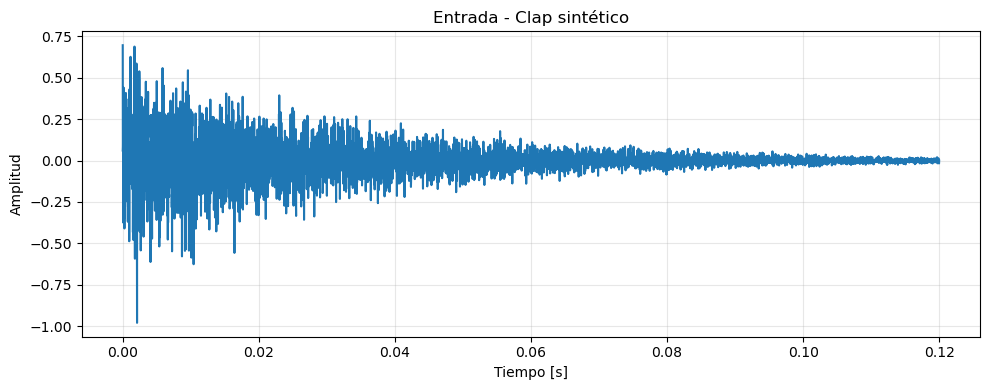

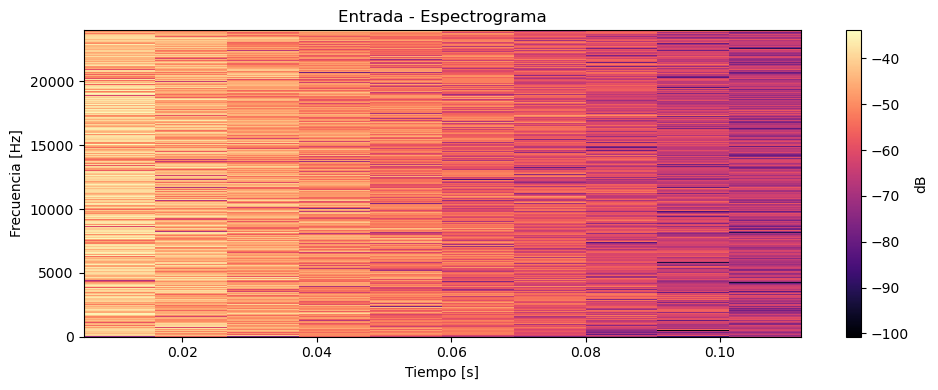

Salida - Sala simulada


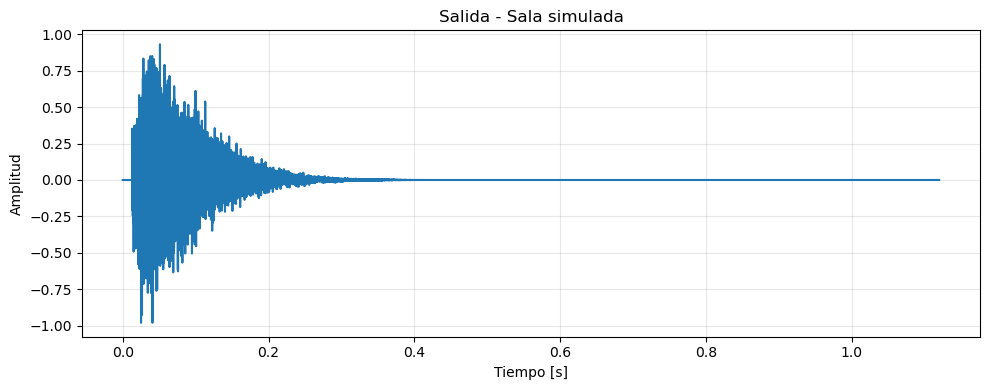

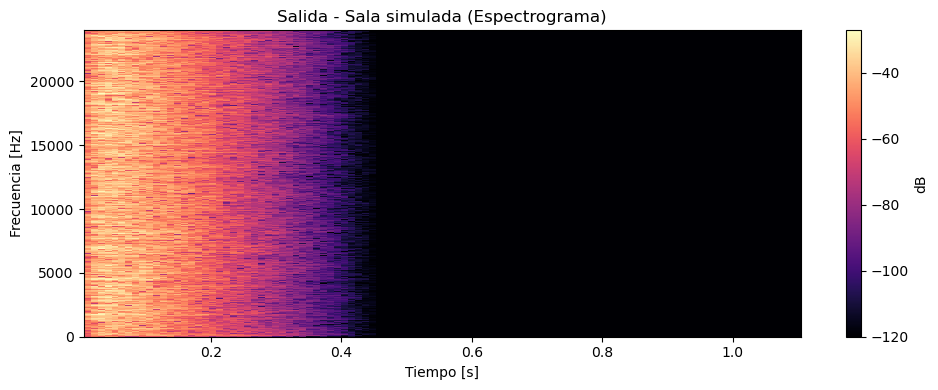

In [11]:
# Demostración básica: impulso sintético -> IR (sala) -> salida
sr = 48000
x = make_synthetic_clap(sr=sr)
ir_room = simulate_room_ir(sr=sr, room_dim=(9.0, 6.0, 3.2), absorption=0.25, max_order=12)
y_room = apply_ir(x, ir_room)

print('Entrada (clap sintético)')
play(x, sr)
plot_waveform(x, sr, 'Entrada - Clap sintético')
plot_spectrogram(x, sr, 'Entrada - Espectrograma')

print('Salida - Sala simulada')
play(y_room, sr)
plot_waveform(y_room, sr, 'Salida - Sala simulada')
plot_spectrogram(y_room, sr, 'Salida - Sala simulada (Espectrograma)')


Salida - Estructura escalonada (modelo simplificado)


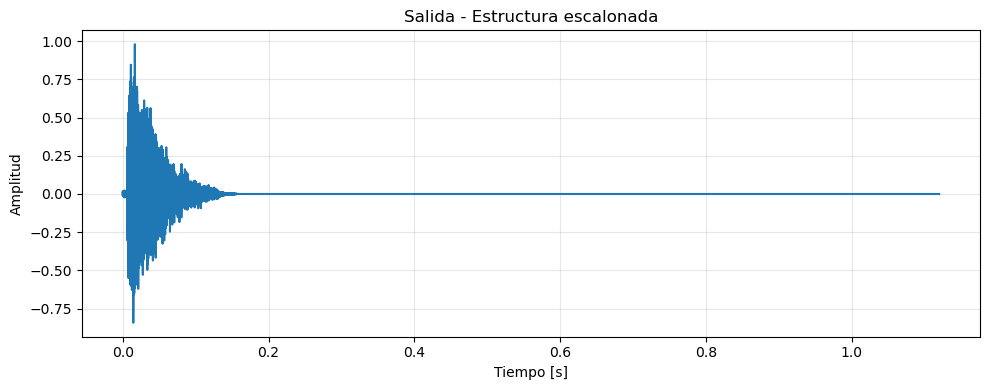

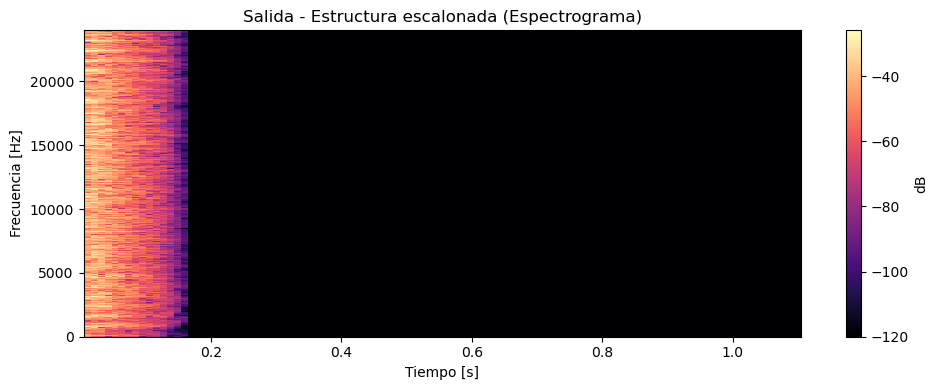

In [12]:
# Demostración: impulso -> estructura escalonada (patrón discreto)
sr = 48000
x = make_synthetic_clap(sr=sr)
ir_steps = stepped_structure_ir(sr=sr, base_delay_ms=6.0, step_delta_ms=1.3, accel_ms=-0.02, num_steps=35, decay=0.9)
y_steps = apply_ir(x, ir_steps)

print('Salida - Estructura escalonada (modelo simplificado)')
play(y_steps, sr)
plot_waveform(y_steps, sr, 'Salida - Estructura escalonada')
plot_spectrogram(y_steps, sr, 'Salida - Estructura escalonada (Espectrograma)')


In [13]:
# Exploración interactiva con ipywidgets
@widgets.interact(
    modo=widgets.Dropdown(options=['Sala (Pyroomacoustics)', 'Estructura Escalonada'], value='Sala (Pyroomacoustics)'),
    sr=widgets.IntSlider(48000, min=8000, max=96000, step=1000, description='sr'),
    # Parametros sala
    Lx=widgets.FloatSlider(9.0, min=3.0, max=30.0, step=0.5, description='Lx [m]'),
    Ly=widgets.FloatSlider(6.0, min=3.0, max=20.0, step=0.5, description='Ly [m]'),
    Lz=widgets.FloatSlider(3.2, min=2.0, max=10.0, step=0.2, description='Lz [m]'),
    absorption=widgets.FloatSlider(0.25, min=0.05, max=0.9, step=0.05, description='Abs'),
    max_order=widgets.IntSlider(12, min=1, max=50, step=1, description='Orden'),
    # Parametros escalera
    base_delay_ms=widgets.FloatSlider(6.0, min=1.0, max=20.0, step=0.2, description='t0 [ms]'),
    step_delta_ms=widgets.FloatSlider(1.3, min=0.1, max=5.0, step=0.1, description='Delta t [ms]'),
    accel_ms=widgets.FloatSlider(-0.02, min=-0.1, max=0.1, step=0.01, description='acel [ms]'),
    num_steps=widgets.IntSlider(35, min=5, max=80, step=1, description='pasos'),
    decay=widgets.FloatSlider(0.9, min=0.5, max=0.99, step=0.01, description='decae'),
)
def demo(modo, sr, Lx, Ly, Lz, absorption, max_order, base_delay_ms, step_delta_ms, accel_ms, num_steps, decay):
    x = make_synthetic_clap(sr=sr)
    if 'Sala' in modo:
        ir = simulate_room_ir(sr=sr, room_dim=(Lx, Ly, Lz), absorption=absorption, max_order=max_order)
        title = 'Salida - Sala simulada'
    else:
        ir = stepped_structure_ir(sr=sr, base_delay_ms=base_delay_ms, step_delta_ms=step_delta_ms, accel_ms=accel_ms, num_steps=num_steps, decay=decay)
        title = 'Salida - Estructura escalonada'
    y = apply_ir(x, ir)
    print(title)
    play(y, sr)
    plot_waveform(y, sr, title)
    plot_spectrogram(y, sr, title + ' (Espectrograma)')
    return y


interactive(children=(Dropdown(description='modo', options=('Sala (Pyroomacoustics)', 'Estructura Escalonada')…

## Usar una respuesta al impulso medida (IR real)

- Si cuentas con una IR medida (por ejemplo, un archivo .wav con la respuesta al impulso de un espacio o estructura), cargala y aplicala por convolucion.
- La IR debe estar idealmente normalizada y con la misma frecuencia de muestreo que la senal de entrada (o se re-muestrea).

In [ ]:
# Ejemplo para IR medida (ajustar la ruta)
# ir_path = 'ruta/a/tu/impulse_response.wav'
# x_path = 'ruta/a/tu/entrada.wav'  # audio de ejemplo
#
# x, sr_x = load_audio(x_path, target_sr=None, mono=True)
# ir, sr_ir = load_audio(ir_path, target_sr=sr_x, mono=True)
# y = apply_ir(x, ir)
# play(y, sr_x)
# plot_waveform(y, sr_x, 'Salida - IR medida')
# plot_spectrogram(y, sr_x, 'Salida - IR medida (Espectrograma)')
# save_audio('salida_convolucion.wav', y, sr_x)  # opcional
